# 先简单看看dynamic_rnn参数
num_units: 表示的是LSTM中隐含状态的维度    
X = np.random.randn(3, 6, 4)    
\# X的第一维度是batch，3个batch ，每个batch 6个数据就是序列长度为6； 4是指每个xt的size；比如你输入的word是one hot表示的； 
    
X_lengths = [6, 4, 6]    
#这个X_lengths赋值给了sequence_length，要仔细理解，这里是说虽然有3个batch，但每个batch的seq并不一样；    
cell到底被call 几次，跟X的每个batch的sequence 相等； 
    
states形状为[2，batch_size, cell.output_size ]
states[0] 为[btach_size， c]
states[1] 为[batch_size,  h]
    
dynamic_rnn不同的batch序列长度可以不一样，例如第一个batch长度为10，第二个batch长度为20，但是static_rnn不同的batch序列长度必须是相同的，都必须是num_steps

    
# 返回值：    

(outputs, state),其中：
outputs： RNN输出Tensor.    
    
如果time_major == False(默认),这将是shape为[batch_size, max_time, cell.output_size]的Tensor.    
如果time_major == True,这将是shape为[max_time, batch_size, cell.output_size]的Tensor.    
    
state： 最终的状态.    
    
一般情况下state的形状为 [batch_size, cell.output_size ]    
如果cell是LSTMCells,则state将是包含每个单元格的LSTMStateTuple的元组，state的形状为[2，batch_size, cell.output_size ]    


In [51]:
import tensorflow as tf
import numpy as np
 
def dynamic_rnn(rnn_type='lstm'):
    # 创建输入数据,3代表batch size,6代表输入序列的最大步长(max time),4代表每个序列的维度
    X = np.random.randn(3, 6, 4)
    
    # 第二个输入的实际长度为4
    # Leo 输出发现只是将数据值设置为0
    X[1, 4:] = 0
    

    #记录三个输入的实际步长
    #同样将X[1]的第4，5个输入设置为0，但X_lengths中的4换成5，
    #你会发现X[1, 4]本来是0，现在有值了；
    X_lengths = [6, 4, 6]

    rnn_hidden_size = 5
    if rnn_type == 'lstm':
        cell = tf.contrib.rnn.BasicLSTMCell(num_units=rnn_hidden_size)#, state_is_tuple=True)
    else:
        cell = tf.contrib.rnn.GRUCell(num_units=rnn_hidden_size)
 
    outputs, last_states = tf.nn.dynamic_rnn(
        cell=cell,
        dtype=tf.float64,
        sequence_length=X_lengths,
        inputs=X)
    
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        o1, s1 = session.run([outputs, last_states])
        print(np.shape(o1))
        print(o1)
        print(np.shape(s1))
        print(s1)
 
 
if __name__ == '__main__':
    tf.reset_default_graph()
    dynamic_rnn(rnn_type='lstm')

(3, 6, 4)
[[[-0.51781413  0.2798878   0.5479591  -0.3450468 ]
  [-0.84058338  0.45583734  0.73483868  0.92226458]
  [ 0.80665562 -0.732291   -0.46870321 -0.79555566]
  [-0.19605282  0.68682057  0.34489867  0.16710321]
  [ 0.43047299 -0.79802776 -0.88335483 -0.82722586]
  [ 0.66775192  0.34726309 -0.36279857 -0.46216526]]

 [[ 0.17166029  0.25516442  0.09982899 -0.0935686 ]
  [-0.04496434 -0.12517006 -0.39267742  0.3866916 ]
  [-0.63027398 -0.02178966  0.61695791 -0.21741406]
  [-0.90628504  0.55064099  0.92642572  0.69338204]
  [ 0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.        ]]

 [[-0.81471642  0.64972702  0.83499816  0.69913931]
  [-0.19088638 -0.90647851 -0.54513178 -0.45435217]
  [ 0.31031945  0.5115878   0.61761049  0.26238552]
  [-0.11885917 -0.34360088 -0.48843955  0.10779271]
  [ 0.84712344 -0.33245649 -0.58795759  0.47396678]
  [ 0.80700684  0.39896279 -0.31146126  0.54892673]]]
(3, 4)
[[ 0.66775192  0.34726309 -0.36279857 -0.

# 数据 
比如：0-2∏ 中取10个连续数的sin值作为训练数据，在取第11个为label；     
创建这样的数据集1000个，然后lstm是模型通过前10个预测第11个；     
看调试代码：     
第一张图是看到X是sin(0,2∏)【注意x的值是竖坐标，横坐标只是简单的index，没意思】,    
第二张图显示了6组训练数据集label      
最后一张是训练好了之后，我们用一堆测试数据经过模型得到一系列prediction数据，就是给你一堆“10个连续数”，然后lstm得到第11个，这些“第11”个数值就是prediction； 对比的就是通过sin函数算出来的第11个数值；数据很多，都可以组成正玄；     


In [180]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

#### 1.  定义RNN的参数。

In [181]:
HIDDEN_SIZE = 30                            # LSTM中隐藏节点的个数。
NUM_LAYERS = 2                              # LSTM的层数。
TIMESTEPS = 10                              # 循环神经网络的训练序列长度。
TRAINING_STEPS = 1000                      # 训练轮数。
BATCH_SIZE = 32                             # batch大小。
TRAINING_EXAMPLES = 100                   # 训练数据个数。
TESTING_EXAMPLES = 100                    # 测试数据个数。
SAMPLE_GAP = 0.01                           # 采样间隔。

#### 2.  产生正弦数据。

In [182]:

#函数使用
#generate_data(np.sin(np.linspace(0, test_start, TRAINING_EXAMPLES + TIMESTEPS, dtype=np.float32)))
def generate_data(seq):
    X = []
    Y = []
    #要预留出一个Step,i最大为Len - TIMESTEPS；
    #          [...step...]
    #[         i          ]
    #用sin函数前面TIMESTEPS个点的信息，预测第i+TIMESTEPS点的函数值
    for i in range(len(seq) - TIMESTEPS):            
        X.append([seq[i:i+TIMESTEPS]])
        Y.append([seq[i+TIMESTEPS]])
    return np.array(X,dtype=np.float32),np.array(Y,dtype=np.float32)

#### 3. 定义网络结构和优化步骤。

In [183]:
def lstm_model(X, y, is_training):
    # 使用多层的LSTM结构。
    cell = tf.nn.rnn_cell.MultiRNNCell([
        tf.nn.rnn_cell.BasicLSTMCell(HIDDEN_SIZE) 
        for _ in range(NUM_LAYERS)])    

    # 使用TensorFlow接口将多层的LSTM结构连接成RNN网络并计算其前向传播结果。
    outputs, _ = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32, time_major=True)
    output = outputs[:, -1, :]

    # 对LSTM网络的输出再做加一层全链接层并计算损失。注意这里默认的损失为平均
    # 平方差损失函数。
    predictions = tf.contrib.layers.fully_connected(
        output, 1, activation_fn=None)
    
    # 只在训练时计算损失函数和优化步骤。测试时直接返回预测结果。
    if not is_training:
        return predictions, None, None
        
    # 计算损失函数。
    loss = tf.losses.mean_squared_error(labels=y, predictions=predictions)

    # 创建模型优化器并得到优化步骤。
    train_op = tf.contrib.layers.optimize_loss(
        loss, tf.train.get_global_step(),
        optimizer="Adagrad", learning_rate=0.1)
    return outputs, predictions, loss, train_op

#### 4. 定义测试方法。

In [184]:
def run_eval(sess, test_X, test_y):
    # 将测试数据以数据集的方式提供给计算图。
    ds = tf.data.Dataset.from_tensor_slices((test_X, test_y))
    ds = ds.repeat().batch(1)
    X, y = ds.make_one_shot_iterator().get_next()
    
    # 调用模型得到计算结果。这里不需要输入真实的y值。
    with tf.variable_scope("model", reuse=True):
        prediction, _, _ = lstm_model(X, [0.0], False)
        
    
    # 将预测结果存入一个数组。
    predictions = []
    labels = []

    for i in range(TESTING_EXAMPLES - 1):
        p, l = sess.run([prediction, y])
        print(p,l)
        predictions.append(p)
        labels.append(l)

    # 计算rmse作为评价指标。
    predictions = np.array(predictions).squeeze()
    labels = np.array(labels).squeeze()
    rmse = np.sqrt(((predictions - labels) ** 2).mean(axis=0))
    print("Root Mean Square Error is: %f" % rmse)
    
    #对预测的sin函数曲线进行绘图。
    plt.figure()
    plt.plot(predictions, label='predictions')
    plt.plot(labels, label='real_sin')
    plt.legend()
    plt.show()

#### 5. 执行训练和测试。

In [212]:
tf.reset_default_graph()

# 将训练数据以数据集的方式提供给计算图。
#《TensorFlow全新的数据读取方式：Dataset API入门教程》
test_start = TRAINING_EXAMPLES  * SAMPLE_GAP
test_end = test_start + ( TESTING_EXAMPLES) * SAMPLE_GAP


train_X, train_y = generate_data(np.sin(np.linspace(
    0, test_start, TRAINING_EXAMPLES + TIMESTEPS, dtype=np.float32)))
test_X, test_y = generate_data(np.sin(np.linspace(
    test_start, test_end, TESTING_EXAMPLES + TIMESTEPS, dtype=np.float32)))

ds = tf.data.Dataset.from_tensor_slices((train_X, train_y))
ds = ds.repeat().shuffle(1000).batch(BATCH_SIZE)
xx, yy = ds.make_one_shot_iterator().get_next()


# 定义模型，得到预测结果、损失函数，和训练操作。
with tf.variable_scope("model"):
    outputs, _, loss, train_op = lstm_model(xx, yy, True)
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())   
    
    # 训练模型。
    for i in range(TRAINING_STEPS):
        dx,dy, oputs, _, l = sess.run([xx,yy,outputs, train_op, loss])
        #print("dataset:",dx.shape,dy.shape,oputs.shape)
        #dataset: (32, 1, 10) (32, 1) (32, 1, 30)
        if i % 100 == 0:
            print("train step: " + str(i) + ", loss: " + str(l))
    
    # 使用训练好的模型对测试数据进行预测。
    print (" ")
    print ("Evaluate model after training.")
    run_eval(sess, test_X, test_y)

type outputs: Tensor("model/rnn/transpose_1:0", shape=(?, 1, 30), dtype=float32)
type outputs: Tensor("model/strided_slice:0", shape=(?, 30), dtype=float32)


ValueError: not enough values to unpack (expected 4, got 3)

## 调试

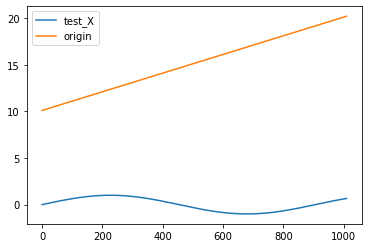

type outputs: Tensor("model_3/rnn/transpose_1:0", shape=(?, 1, 30), dtype=float32, device=/device:GPU:1)
type outputs: Tensor("model_3/strided_slice:0", shape=(?, 30), dtype=float32, device=/device:GPU:1)
tout: (32, 30)
tX[0,0,:] 10
train step: 0,loss: 0.5426087
train step: 100,loss: 0.2601237
tout: (32, 30)
tX[0,0,:] 10
train step: 200,loss: 0.06721783
train step: 300,loss: 0.023848925
tout: (32, 30)
tX[0,0,:] 10
train step: 400,loss: 0.0092338305
train step: 500,loss: 0.0061525307
tout: (32, 30)
tX[0,0,:] 10
train step: 600,loss: 0.0054203616
train step: 700,loss: 0.0051670973
tout: (32, 30)
tX[0,0,:] 10
train step: 800,loss: 0.004006881
train step: 900,loss: 0.0055895196


No handles with labels found to put in legend.


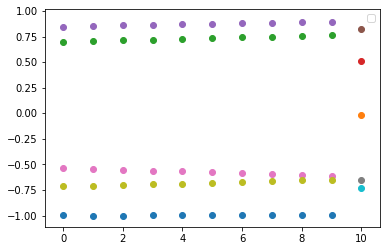

Evaluate model after training.
type outputs: Tensor("model_4/rnn/transpose_1:0", shape=(?, 1, 30), dtype=float32, device=/device:GPU:1)
type outputs: Tensor("model_4/strided_slice:0", shape=(?, 30), dtype=float32, device=/device:GPU:1)
RMSE 0.06922857


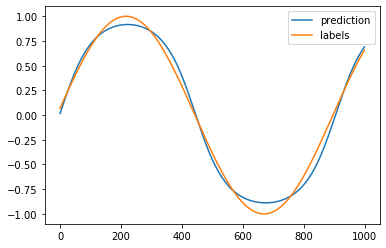

ok


In [214]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

hidden_size = 30   # LSTM 中隐藏节点的个数   //TODO 这个size是是什么意思  //是lstm模块输出单元的维度，
num_layers = 2     # LSTM 的层数
timestep = 10      # 循环神经网络的训练序列长度
train_step = 1000  # 训练的轮数
batch_size = 32     # batch的大小
training_examples = 1000  # 训练数据的个数
test_examples = 1000        # 测试数据的个数
sample_gap = 0.01           # 采样间隔

# 使用序列的第i项以及后面的timestep-1 作为输入来预测第i+timestep项
def generate_data(seq):
    X = []
    Y = []
    for i in range(len(seq) - timestep):
        X.append([seq[i:i+timestep]])
        Y.append([seq[i + timestep]])
    return np.array(X,dtype=np.float32),np.array(Y,dtype=np.float32)
# 在这里有一些问题，这些LSTM的结构是什么样的
def lstm_model(X,y,is_train):
    # 使用多层的LSTM结构
    cell = tf.nn.rnn_cell.MultiRNNCell([tf.nn.rnn_cell.BasicLSTMCell(hidden_size) for _ in range(num_layers)])
    # 使用Tensorflow 接口将多层的LSTM结构连接成RNN网络并计算其前向传播结果
    outputs,_ = tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)
    print("type outputs:", outputs)
    # output 是顶层LSTM在每一步的输出结果，它的维度是[batch_size,timestep,hidden_size],在本问题中只关心最后一个输出
    outputs = outputs[:,-1,:]
    print("type outputs:", outputs)
    # 对lstm层的输出再加上上一个全连接层。
    predictions = tf.contrib.layers.fully_connected(outputs,1,activation_fn=None)
    if not is_train:
        return None, predictions,None,None
    # 使用均方误差作为损失函数
    loss = tf.losses.mean_squared_error(labels=y,predictions=predictions)

    train_op = tf.contrib.layers.optimize_loss(loss,tf.train.get_global_step(),optimizer="Adagrad",learning_rate=0.01)
    return outputs, predictions, loss, train_op

def train(sess,train_X,train_Y):
    # 将训练数据以数据集的方式提供给计算图
    ds = tf.data.Dataset.from_tensor_slices((train_X,train_Y))
    ds = ds.repeat().shuffle(10000).batch(batch_size)
    X,y = ds.make_one_shot_iterator().get_next()
    # 调用模型，得到预测结果，损失函数以及训练操作
    with tf.variable_scope("model",reuse=tf.AUTO_REUSE):
        out, predicttion,loss,train_op = lstm_model(X,y,True)
    # 初始化变量
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    plt.figure()


    for i in range(train_step):
        tout, tp,tX, _,l = sess.run([out, predicttion,X, train_op,loss])
        if i % 200 == 0:
            print("tout:",tout.shape)
            print("tX[0,0,:]",len(tX[0,0,:]))
            plt.scatter([i for i in range(10)], tX[0,0,:])
            plt.scatter([10 ], tp[0,:])
            
        if i % 100 == 0:     
            print("train step: " + str(i) + ",loss: "+ str(l))
            
    plt.legend()
    plt.show()        
    #保存模型，下次可以直接加载模型
    saver.save(sess,"model_basic_RNN/model.ckpt")


def run_eval(sess,test_X,test_Y):
    ds = tf.data.Dataset.from_tensor_slices((test_X,test_Y))
    ds = ds.batch(1)
    X,y = ds.make_one_shot_iterator().get_next()

    with tf.variable_scope("model",reuse=True):
        _, prediction,_,_ = lstm_model(X,[0.0],False)

    predictions = []
    labels = []
    for i in range(test_examples):
        p,l = sess.run([prediction,y])
        predictions.append(p)
        labels.append(l)

    predictions = np.array(predictions).squeeze()
    labels = np.array(labels).squeeze()
    rmse = np.sqrt(((predictions - labels) ** 2).mean(axis =0 ))
    print("RMSE",rmse)

    plt.figure()
    plt.plot(predictions,label="prediction")
    plt.plot(labels,label="labels")
    plt.legend()
    plt.show()
    print("ok")
    return predictions,labels

tf.config.set_soft_device_placement(True)
with tf.device('/device:GPU:1'):
    test_start = (training_examples + timestep) * sample_gap
    test_end = test_start + (test_examples + timestep) * sample_gap
    train_X,train_Y = generate_data(np.sin(np.linspace(0,test_start,training_examples+timestep,dtype=np.float32)))
    test_X,test_Y = generate_data(np.sin(np.linspace(0, 7,test_examples+timestep,dtype=np.float32)))

    plt.figure()
    plt.plot(np.sin(np.linspace(0, 7,test_examples+timestep,dtype=np.float32)),label='test_X')
    plt.plot(np.linspace(test_start,test_end,test_examples+timestep,dtype=np.float32),label='origin')
    plt.legend()
    plt.show()
    
    with tf.Session() as sess:
        # get error 
        # Evaluate model before training.
        # run_eval(sess,test_X,test_Y)
        
        train(sess,train_X,train_Y)
        
        print ("Evaluate model after training.")
        p,l = run_eval(sess,test_X,test_Y)


train step: 0, loss: 0.5354545
train step: 10, loss: 0.33346263
train step: 20, loss: 0.40211692
train step: 30, loss: 0.38512525
train step: 40, loss: 0.3216974
train step: 50, loss: 0.29653758
train step: 60, loss: 0.21525076
train step: 70, loss: 0.1624615
train step: 80, loss: 0.11927482
train step: 90, loss: 0.12662652
 
Evaluate model after training.
Root Mean Square Error is: 0.293696


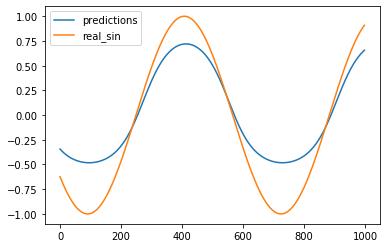

In [190]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

HIDDEN_SIZE = 30                            # LSTM中隐藏节点的个数。
NUM_LAYERS = 2                              # LSTM的层数。
TIMESTEPS = 10                              # 循环神经网络的训练序列长度。
TRAINING_STEPS = 100                      # 训练轮数。
BATCH_SIZE = 32                             # batch大小。
TRAINING_EXAMPLES = 1000                   # 训练数据个数。
TESTING_EXAMPLES = 1000                    # 测试数据个数。
SAMPLE_GAP = 0.01                           # 采样间隔。

tf.reset_default_graph()

def generate_data(seq):
    X = []
    Y = []
    #要预留出一个Step,i最大为Len - TIMESTEPS；
    #          [...step...]
    #[         i          ]
    #用sin函数前面TIMESTEPS个点的信息，预测第i+TIMESTEPS点的函数值
    for i in range(len(seq) - TIMESTEPS):            
        X.append([seq[i:i+TIMESTEPS]])
        Y.append([seq[i+TIMESTEPS]])
    return np.array(X,dtype=np.float32),np.array(Y,dtype=np.float32)

def lstm_model(X, y, is_training):
    # 使用多层的LSTM结构。
    cell = tf.nn.rnn_cell.MultiRNNCell([
        tf.nn.rnn_cell.BasicLSTMCell(HIDDEN_SIZE) 
        for _ in range(NUM_LAYERS)])    

    # 使用TensorFlow接口将多层的LSTM结构连接成RNN网络并计算其前向传播结果。
    outputs, _ = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32, time_major=True)
    output = outputs[:, -1, :]

    # 对LSTM网络的输出再做加一层全链接层并计算损失。注意这里默认的损失为平均
    # 平方差损失函数。
    predictions = tf.contrib.layers.fully_connected(
        output, 1, activation_fn=None)
    
    # 只在训练时计算损失函数和优化步骤。测试时直接返回预测结果。
    if not is_training:
        return predictions, None, None
        
    # 计算损失函数。
    loss = tf.losses.mean_squared_error(labels=y, predictions=predictions)

    # 创建模型优化器并得到优化步骤。
    train_op = tf.contrib.layers.optimize_loss(
        loss, tf.train.get_global_step(),
        optimizer="Adagrad", learning_rate=0.1)
    return outputs, predictions, loss, train_op

def run_eval(sess, test_X, test_y):
    # 将测试数据以数据集的方式提供给计算图。
    ds = tf.data.Dataset.from_tensor_slices((test_X, test_y))
    ds = ds.repeat().batch(1)
    rx, ry = ds.make_one_shot_iterator().get_next()
    
    # 调用模型得到计算结果。这里不需要输入真实的y值。
    with tf.variable_scope("model", reuse=True):
        rprediction, _, _ = lstm_model(rx, [0.0], False)
        
    
    # 将预测结果存入一个数组。
    predictions = []
    labels = []

    for i in range(TESTING_EXAMPLES - 1):
        p, l = sess.run([rprediction, ry])
        predictions.append(p)
        labels.append(l)

    # 计算rmse作为评价指标。
    predictions = np.array(predictions).squeeze()
    labels = np.array(labels).squeeze()
    rmse = np.sqrt(((predictions - labels) ** 2).mean(axis=0))
    print("Root Mean Square Error is: %f" % rmse)
    
    #对预测的sin函数曲线进行绘图。
    plt.figure()
    plt.plot(predictions, label='predictions')
    plt.plot(labels, label='real_sin')
    plt.legend()
    plt.show()
    


# 将训练数据以数据集的方式提供给计算图。
#《TensorFlow全新的数据读取方式：Dataset API入门教程》
test_start = TRAINING_EXAMPLES  * SAMPLE_GAP
test_end = test_start + ( TESTING_EXAMPLES) * SAMPLE_GAP


train_X, train_y = generate_data(np.sin(np.linspace(
    0, test_start, TRAINING_EXAMPLES + TIMESTEPS, dtype=np.float32)))
test_X, test_y = generate_data(np.sin(np.linspace(
    test_start, test_end, TESTING_EXAMPLES + TIMESTEPS, dtype=np.float32)))

ds = tf.data.Dataset.from_tensor_slices((train_X, train_y))
ds = ds.repeat().shuffle(1000).batch(BATCH_SIZE)
xx, yy = ds.make_one_shot_iterator().get_next()


# 定义模型，得到预测结果、损失函数，和训练操作。
with tf.variable_scope("model"):
    outputs, _, loss, train_op = lstm_model(xx, yy, True)
    
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())   
    
    # 训练模型。
    for i in range(TRAINING_STEPS):
        dx,dy, oputs, _, l = sess.run([xx,yy,outputs, train_op, loss])
        #print("dataset:",dx.shape,dy.shape,oputs.shape)
        #dataset: (32, 1, 10) (32, 1) (32, 1, 30)
        if i % 10 == 0:
            print("train step: " + str(i) + ", loss: " + str(l))
    
    # 使用训练好的模型对测试数据进行预测。
    print (" ")
    print ("Evaluate model after training.")
    run_eval(sess, test_X, test_y)